In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as transformsV2
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
IMG_SIZE = 128

img_transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToTensor(), transforms.Normalize(0, 1)])
training_dir = '/kaggle/input/cards-image-datasetclassification/train'
training_data = ImageFolder('/kaggle/input/cards-image-datasetclassification/train', 
                            transform = img_transform)
class_mapping = {v: k for k, v in ImageFolder(training_dir).class_to_idx.items()}


In [3]:
def gaussian_noise(image, mean, std):
    noise = np.random.normal(mean, std, image.shape)
    return image + noise

class Combination(nn.Module):
    def __init__(self, _transforms, pre, post):
        super().__init__()
        self.transforms = _transforms
        self.pre = transforms.Compose(pre)
        self.post = transforms.Compose(post)

    def stacked_t(self, t, x):
        lengths = [len(o) for o in x]
        return t(torch.cat(x)).split(lengths)

    def forward(self, x):
        out = [self.pre(x)[None]]
        for t in self.transforms:
            out += self.stacked_t(t, out) # <- for every transform `t` we double
                                          #    the number of instances in` out`
        out = [self.post(o)[0] for o in out]
        return out

img_combs_transform = Combination(pre=[transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToTensor()], 
            post=[transforms.Normalize(0, 1)],
            _transforms=[transforms.GaussianBlur(1, (0.1, 0.5)), transforms.RandomRotation(30)])

# Convolutional Neural Network

A CNN was constructed, taking in a 3-channel 128x128 image and outputting a soft-max normalised vector of length 53, giving the probability for each class. The network consisted of two 2D convolution layers (kernel size = 5), each followed by max-pool layers (kernel size = 2), and four linear layers (sizes = 21025, 1024, 256, 53).

The model was trained in batches of 32 images using the Adam optimiser until the cross-entropy loss on a validation set converged (~8 epochs). The small validation set was used to prevent overfitting on the training dataset. The model achieved a score of 0.9791 on the training dataset and 0.7925 on the test dataset. The model was most confused by number card displaying pictures in their centre.


In [4]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        FIRST_KERNELS = 10
        SECOND_KERNELS = 25
        KERNEL_SIZE = 5
        POOL_SIZE = 4
        FINAL = (((IMG_SIZE - KERNEL_SIZE + 1) // POOL_SIZE) - KERNEL_SIZE + 1) // POOL_SIZE
        self.linear_in_size = SECOND_KERNELS * FINAL * FINAL
        self.conv1 = nn.Conv2d(3, FIRST_KERNELS, KERNEL_SIZE)
        self.pool = nn.MaxPool2d(POOL_SIZE, POOL_SIZE)
        self.conv2 = nn.Conv2d(FIRST_KERNELS, SECOND_KERNELS, KERNEL_SIZE)
#        self.fc1 = nn.Linear(self.linear_in_size, self.linear_in_size)
        self.fc2 = nn.Linear(self.linear_in_size, 8192)
        self.fc3 = nn.Linear(8192, 512)
        self.fc4 = nn.Linear(512, 53)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], self.linear_in_size)
#        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [5]:
train_folder = '../input/cards-image-datasetclassification/train/'
valid_folder = '../input/cards-image-datasetclassification/valid/'
test_folder = '../input/cards-image-datasetclassification/test/'

train_dataset = ImageFolder(train_folder, transform=img_combs_transform)
#train_dataset = ImageFolder(train_folder, transform=img_transform)
val_dataset = ImageFolder(valid_folder, transform=img_transform)
test_dataset = ImageFolder(test_folder, transform=img_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
model = SimpleCardClassifer(num_classes=53)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

SimpleCardClassifer(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 25, kernel_size=(5, 5), stride=(1, 1))
  (fc2): Linear(in_features=900, out_features=8192, bias=True)
  (fc3): Linear(in_features=8192, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=53, bias=True)
)


In [7]:
# Simple training loop
num_epochs = 20
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

last_val_loss = float("inf")
val_inc = 0
for epoch in range(num_epochs):
    print("epoch", epoch)
    # Training phase
    model.train()
    running_loss = 0.0
    cnt = 0
    for img, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        for images in img:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
#            print(images.shape, outputs.shape, labels.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
        print(cnt, end=" ")
        cnt += 1
        
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
    if val_loss > last_val_loss:
        val_inc += 1
        if val_inc >= 2: break
    else: val_inc = 0
    last_val_loss = val_loss


cpu
epoch 0


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/20 - Train loss: 9.93742497970525, Validation loss: 1.7753277769628562
epoch 1


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/20 - Train loss: 6.50784684928742, Validation loss: 1.08019856686862
epoch 2


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/20 - Train loss: 4.899241506490477, Validation loss: 0.81273805510323
epoch 3


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/20 - Train loss: 3.85538520139387, Validation loss: 0.9281466358112839
epoch 4


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/20 - Train loss: 3.0632934232456424, Validation loss: 0.7910612992520603
epoch 5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/20 - Train loss: 2.3160735037869697, Validation loss: 0.963261378036355
epoch 6


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/20 - Train loss: 1.841632179607093, Validation loss: 0.9460299626836237
epoch 7


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/20 - Train loss: 1.5448558639054815, Validation loss: 0.8679630101851697
epoch 8


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/20 - Train loss: 1.2948716265078075, Validation loss: 1.0046053877416647
epoch 9


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/20 - Train loss: 1.2103700117793927, Validation loss: 0.9623973324613752
epoch 10


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/20 - Train loss: 1.0555683433286873, Validation loss: 1.2166698932647706
epoch 11


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/20 - Train loss: 1.038811976275935, Validation loss: 1.2489572331590473


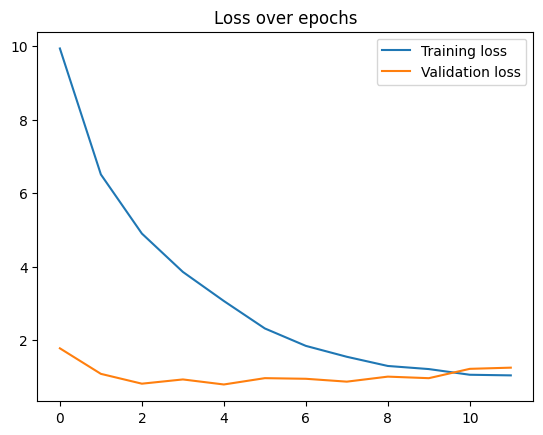

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [9]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

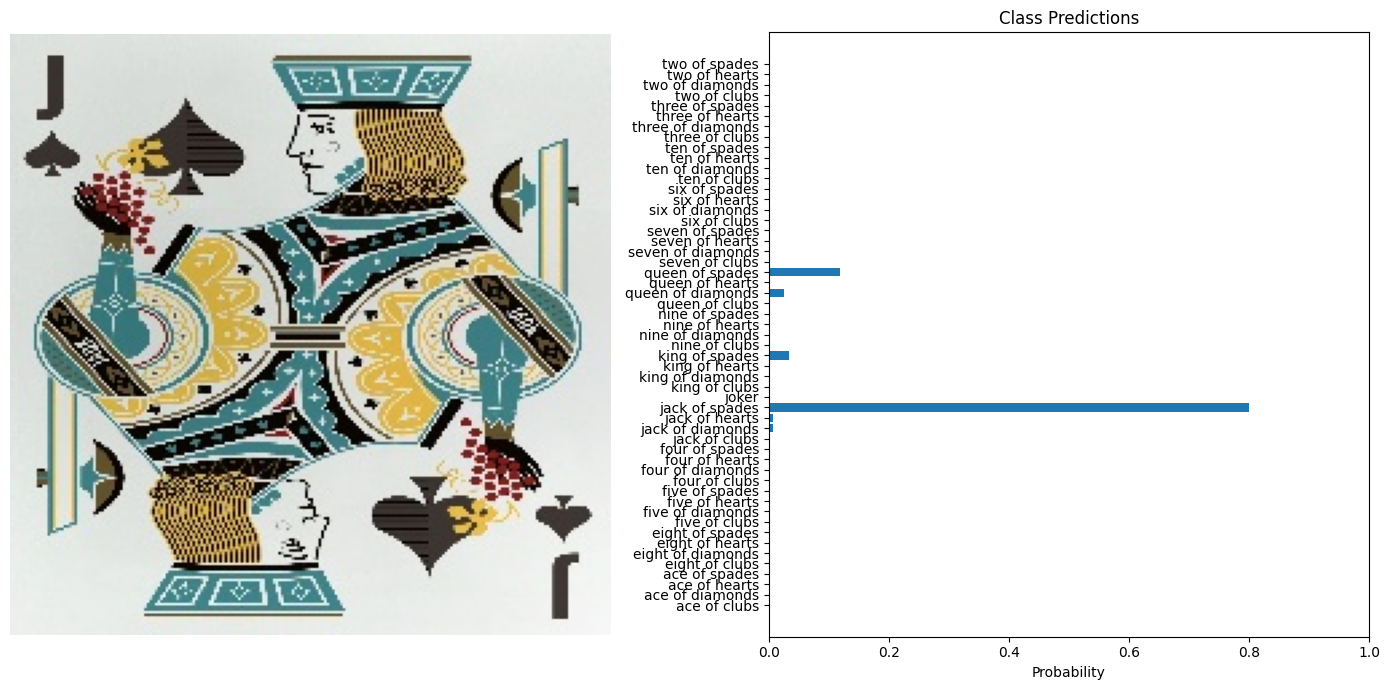

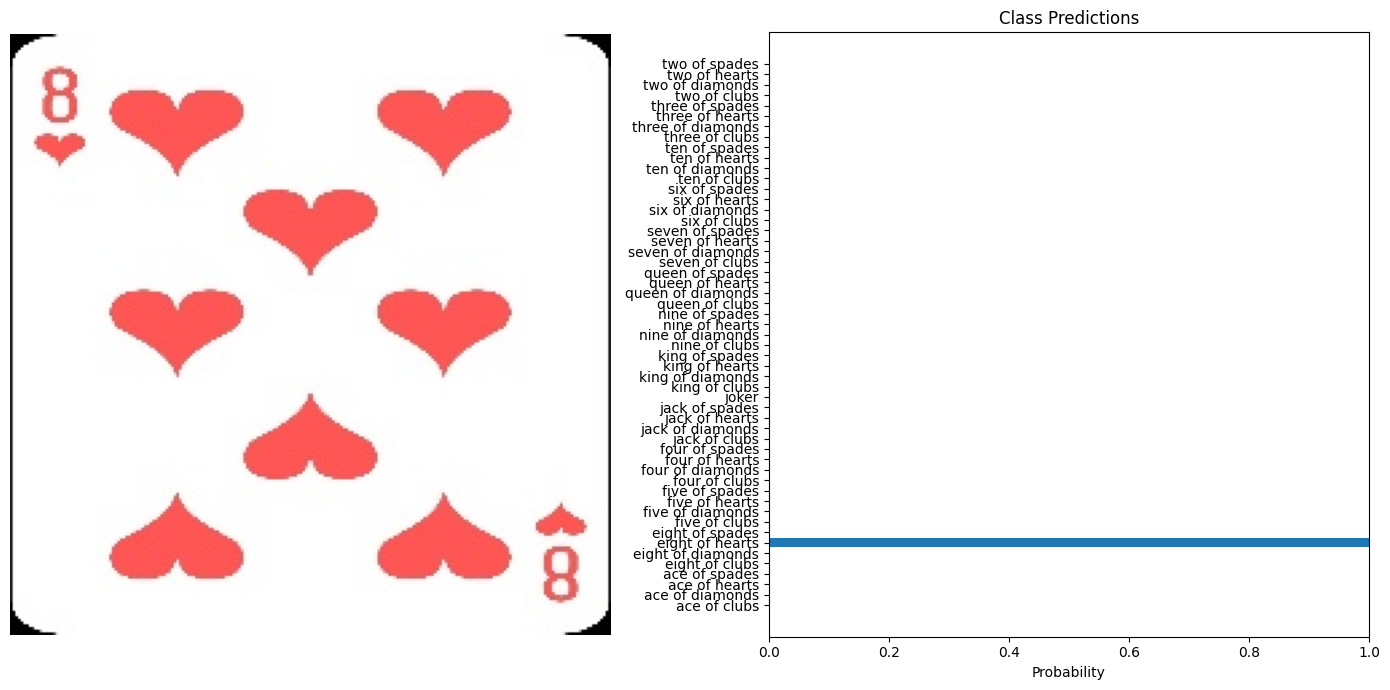

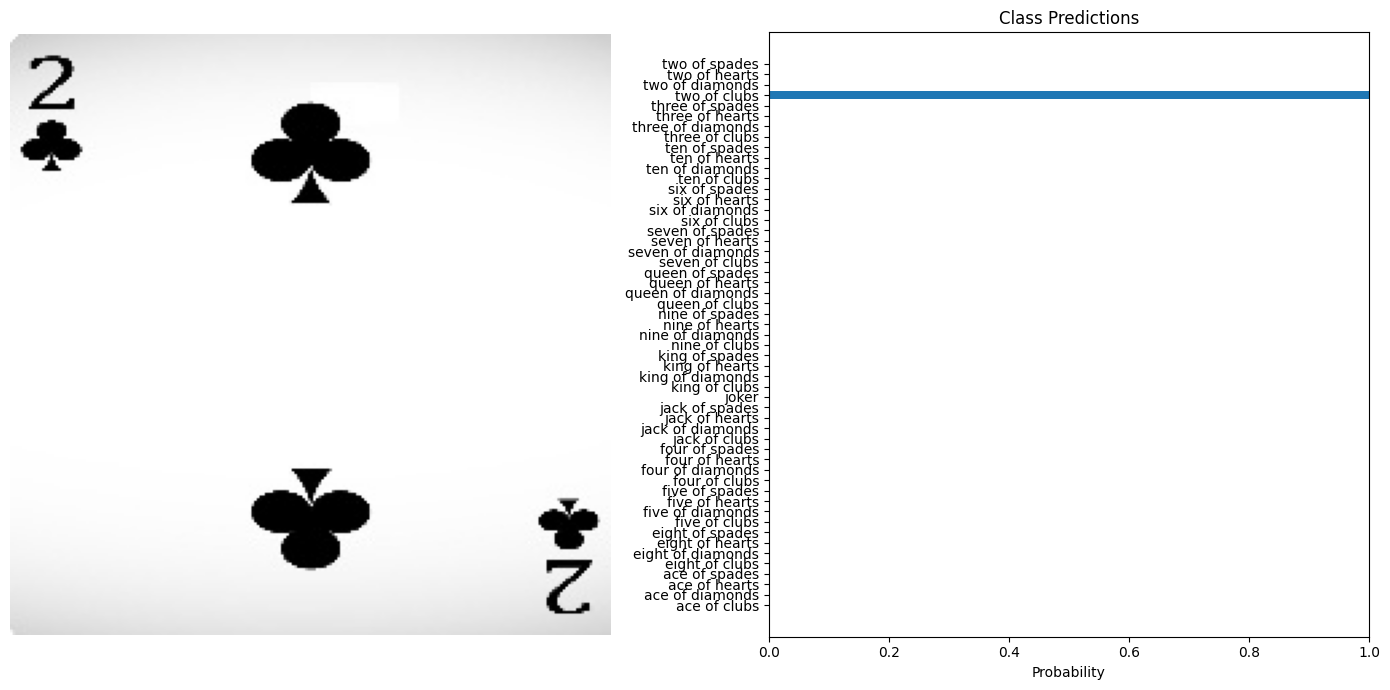

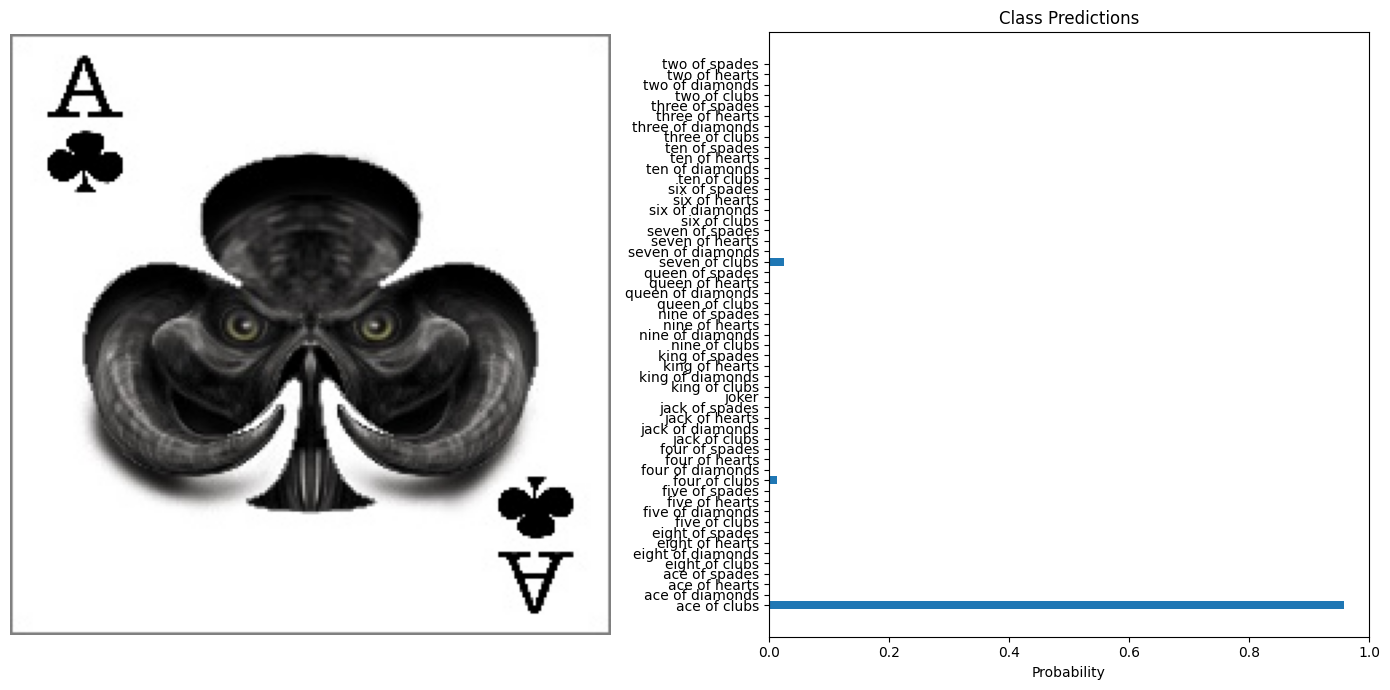

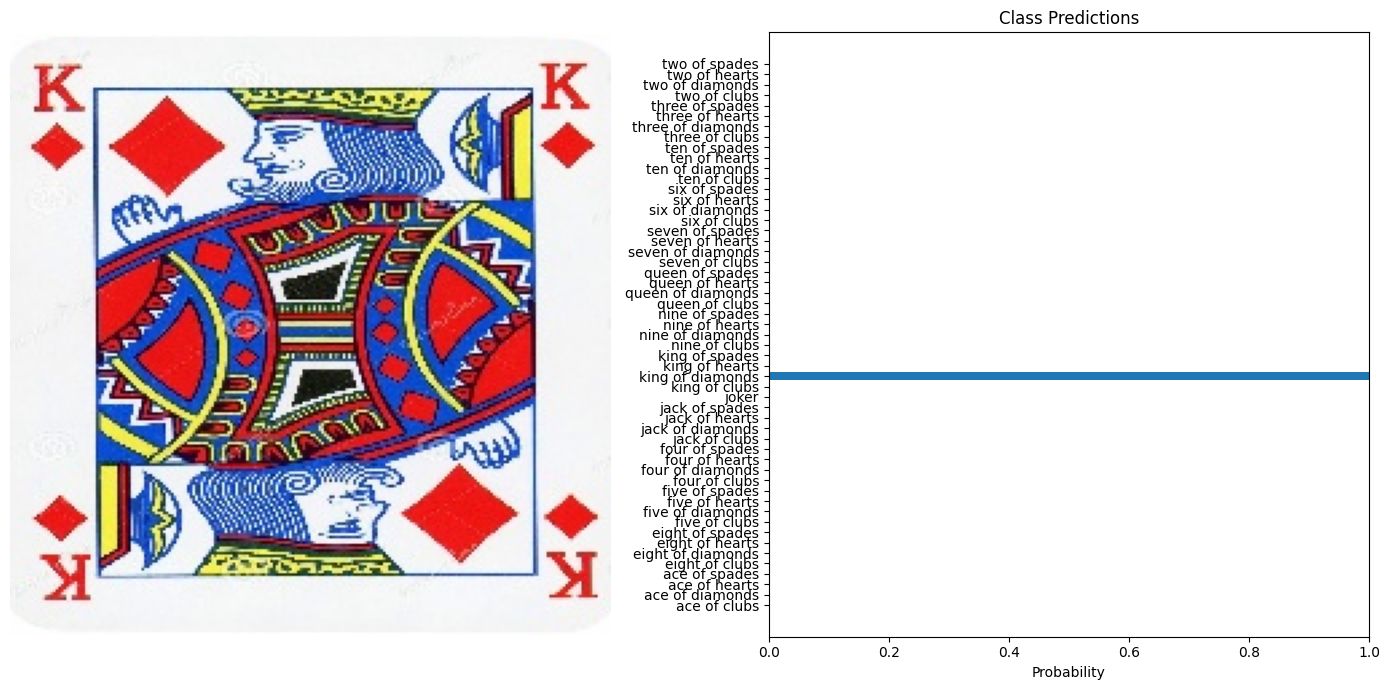

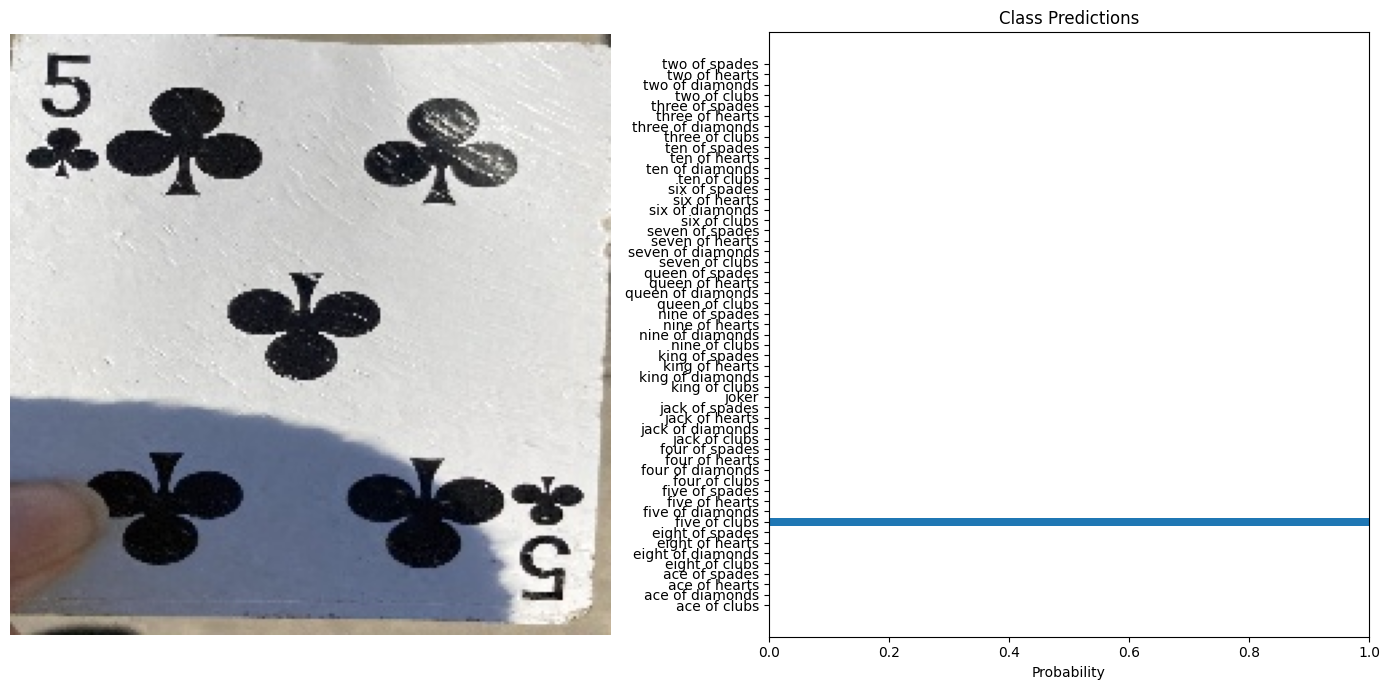

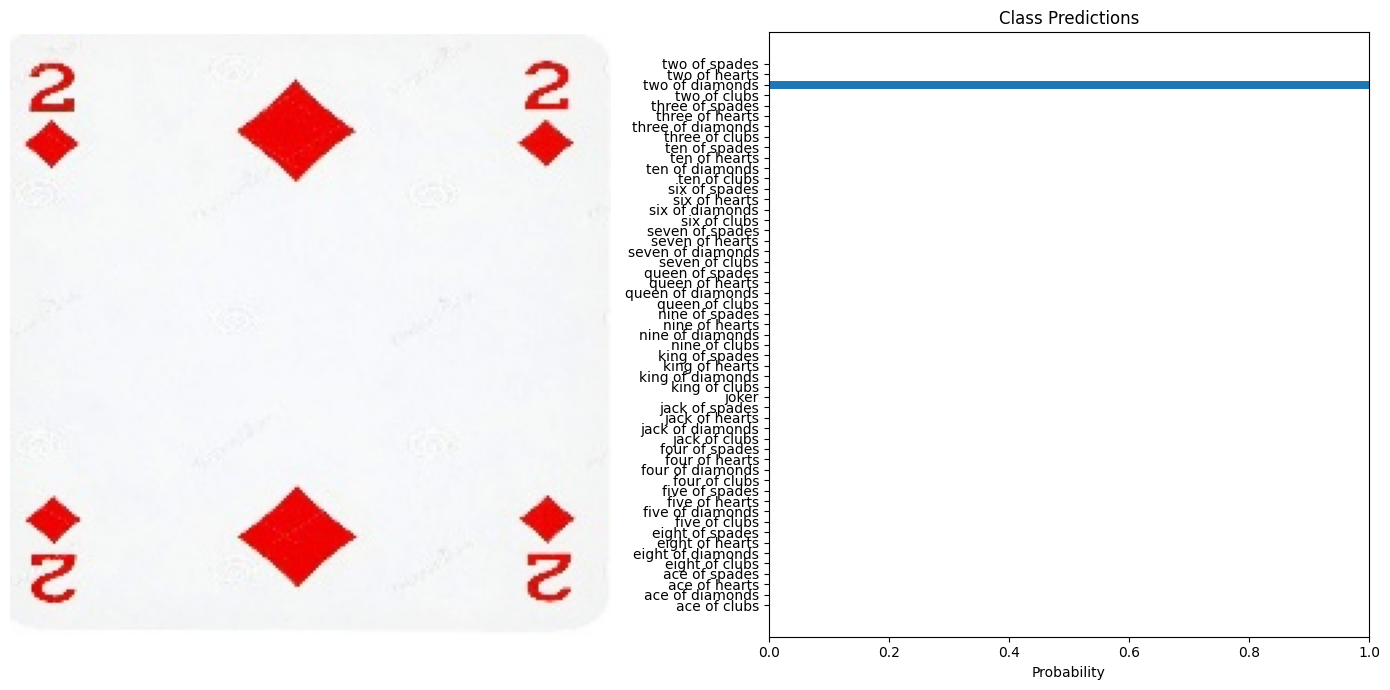

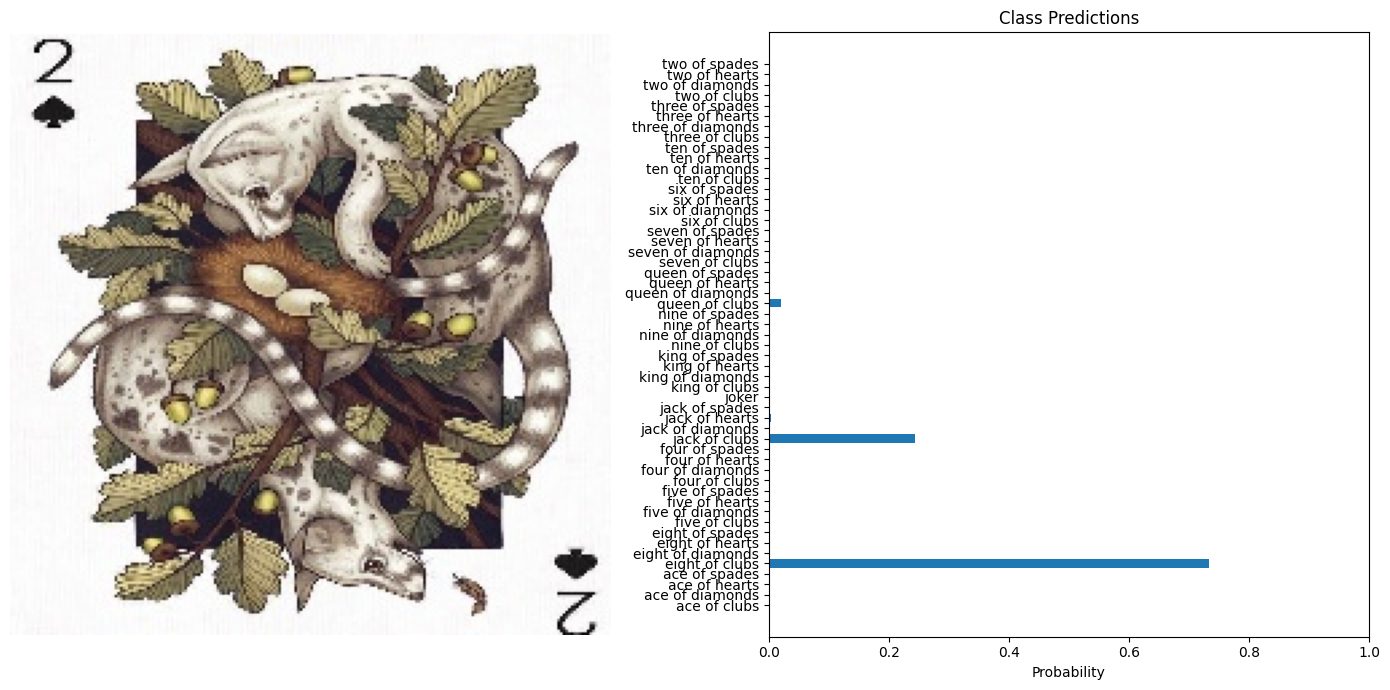

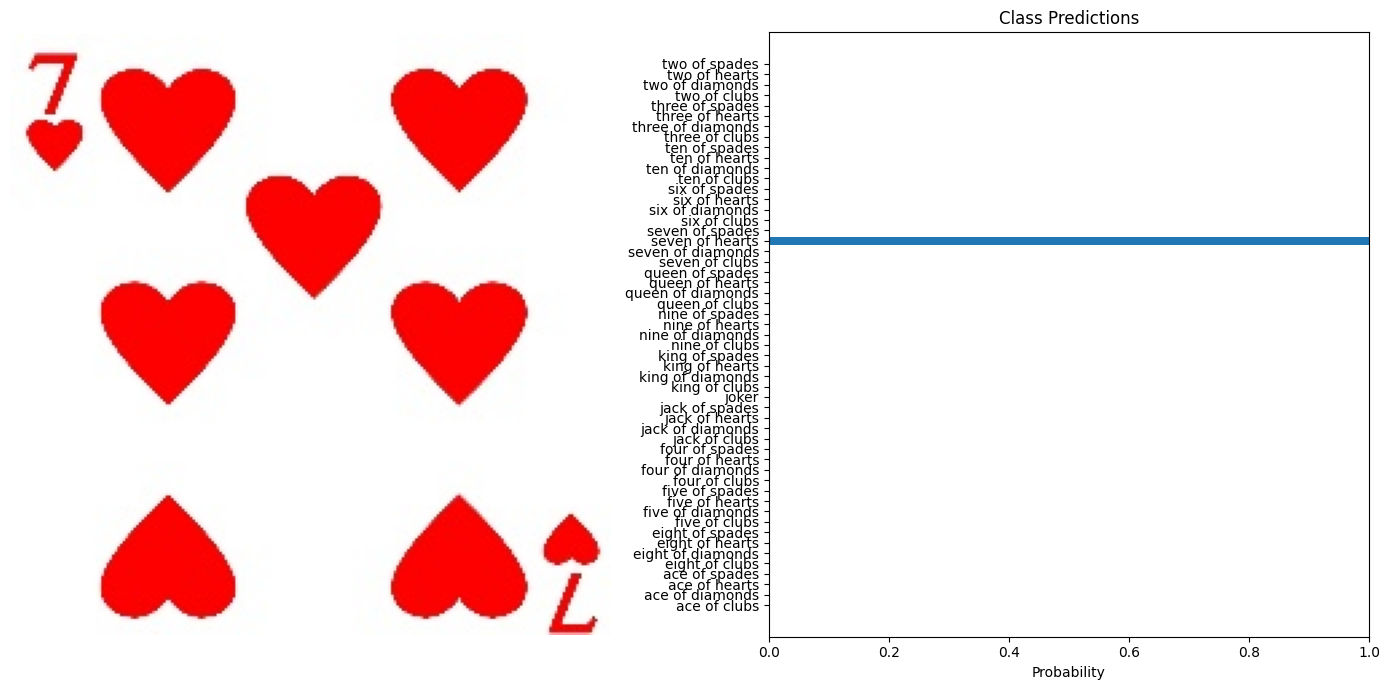

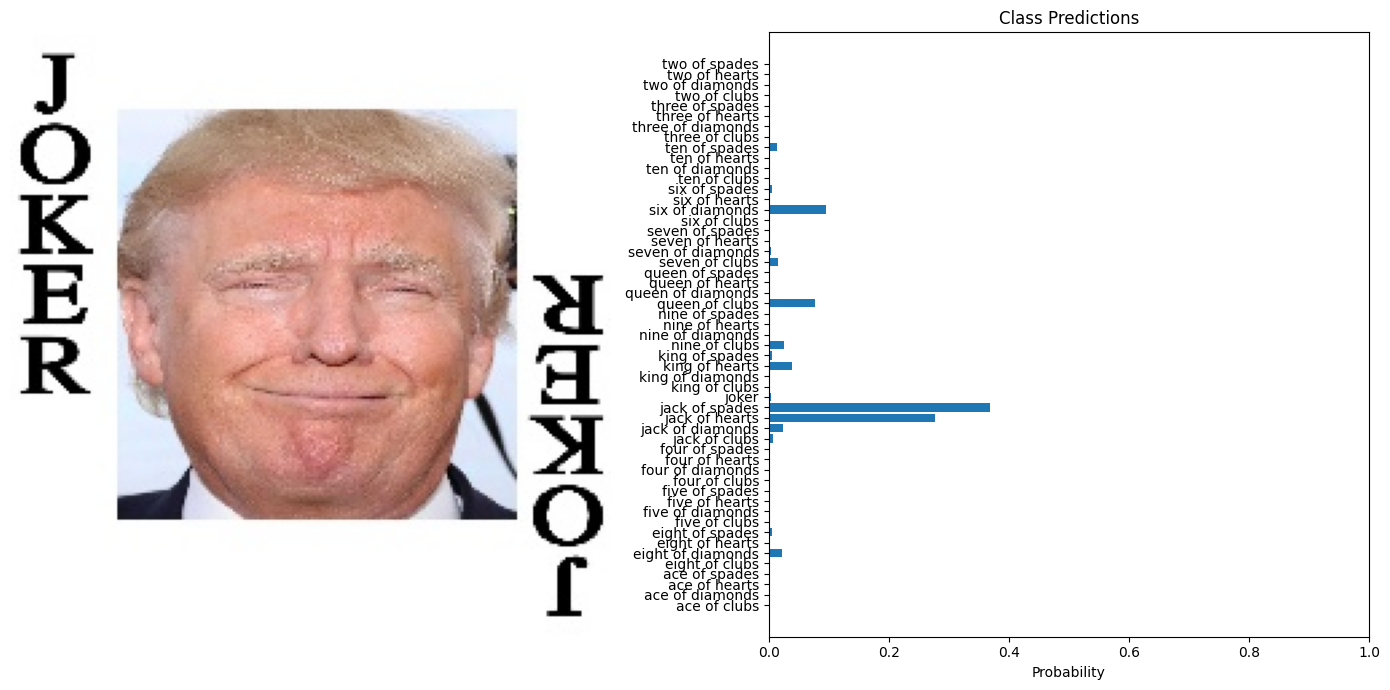

In [10]:
from glob import glob
test_images = glob('../input/cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, img_transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = training_data.classes 
    visualize_predictions(original_image, probabilities, class_names)

In [11]:
# Validation Score
correct = 0
total = 0
running_loss = 0.0
with torch.no_grad():
    for images, labels in val_loader:
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        labels = labels.cpu()     
        outputs = model(images).cpu()
        prediction = np.argmax(outputs, axis=1)
        correct += (prediction == labels).sum().item()
        total += len(prediction)
print("Validation Score:", correct / total)

# Testing Score
correct = 0
total = 0
running_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        labels = labels.cpu()     
        outputs = model(images).cpu()
        prediction = np.argmax(outputs, axis=1)
        correct += (prediction == labels).sum().item()
        total += len(prediction)
print("Test Score:", correct / total)


Validation Score: 0.8
Test Score: 0.8


# Architecture Tuning

| MaxPoolSize | KernelSize | KernelLayers | LinearSize | Score |
|-------------|------------|--------------|------------|-------|
| 4	| 5 | 10 | 1024	| 0.79245
| 2	| 8	| 5	| 8192	| 0.78491
| 6	| 8	| 10 | 1024	| 0.69057
| 4	| 3	| 5	| 8192	| 0.77736
| 2	| 3	| 5	| 1024	| 0.76603
| 6	| 5	| 10 | 8192	| 0.73208
| 4	| 5	| 5	| 1024	| 0.78868
| 2 | 3	| 10 | 8192	| 0.76604
| 6 | 3	| 5	| 1024	| 0.70566
| 6 | 8	| 5	| 8192	| 0.69811
| 4 | 3	| 10 | 1024	| 0.77358
| 2 | 5	| 10 | 8192	| 0.80000
| 4 | 5 | 10 | 8192 | 0.81509

The best score is achieved using a MaxPool Size of 4, a Kernel Size of 5, 10 Kernels, and a Linear Size of 8192.